In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import climlab
from climlab import constants as const
#import cartopy.crs as ccrs  # use cartopy to make some maps

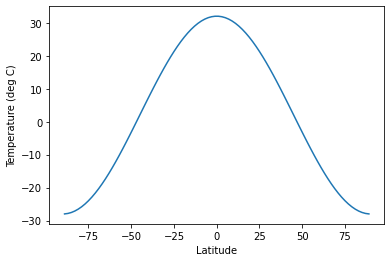

In [2]:
#  First define an initial temperature field
#   that is warm at the equator and cold at the poles
#   and varies smoothly with latitude in between

from climlab.utils import legendre
sfc = climlab.domain.zonal_mean_surface(num_lat=90, water_depth=10.)
lat = sfc.lat.points
initial = 12. - 40. * legendre.P2(np.sin(np.deg2rad(lat)))

fig, ax = plt.subplots()
ax.plot(lat, initial)
ax.set_xlabel('Latitude')
ax.set_ylabel('Temperature (deg C)');

In [3]:
##  Set up the climlab diffusion process

# make a copy of initial so that it remains unmodified
Ts = climlab.Field(np.array(initial), domain=sfc)
# thermal diffusivity in W/m**2/degC
D = 0.55
# create the climlab diffusion process
#  setting the diffusivity and a timestep of ONE MONTH
d = climlab.dynamics.MeridionalHeatDiffusion(name='Diffusion', 
            state=Ts, D=D, timestep=const.seconds_per_month)
print(d)

climlab Process of type <class 'climlab.dynamics.meridional_heat_diffusion.MeridionalHeatDiffusion'>. 
State variables and domain shapes: 
  default: (90, 1) 
The subprocess tree: 
Diffusion: <class 'climlab.dynamics.meridional_heat_diffusion.MeridionalHeatDiffusion'>



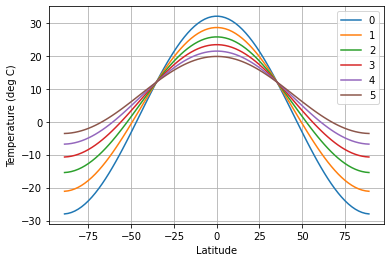

In [4]:
#  We are going to step forward one month at a time
#  and store the temperature each time
n_iter = 5
temp = np.zeros((Ts.size, n_iter+1))
temp[:, 0] = np.squeeze(Ts)
for n in range(n_iter):
    d.step_forward()
    temp[:, n+1] = np.squeeze(Ts)
    
#  Now plot the temperatures
fig,ax = plt.subplots()
ax.plot(lat, temp)
ax.set_xlabel('Latitude')
ax.set_ylabel('Temperature (deg C)')
ax.legend(range(n_iter+1)); ax.grid();

In [12]:
#set up data for alebdo curves
albedo_global_average = 0.354 #data from NCEP values for ASR and Qann
uniform_albedo_vector = np.repeat(albedo_global_average, 94, axis=None)

lat_ncep = np.genfromtxt('lat_ncep.csv', delimiter=',')

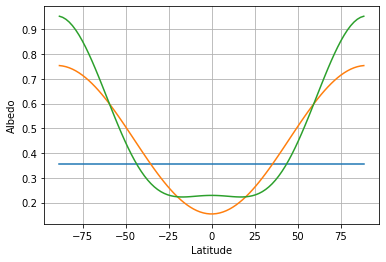

In [17]:
fig,ax = plt.subplots()
ax.plot(lat_ncep, uniform_albedo_vector)
ax.grid();
ax.set_xlabel('Latitude')
ax.set_ylabel('Albedo');


# Add a new albedo curve guess to the previous figure
a_0 = albedo_global_average
a_1 = 0.4 ### edit this number based on observational data!!! 
first_albedo_guess = a0 + a2 * legendre.P2(np.sin(np.deg2rad(lat_ncep)))
ax.plot(lat_ncep, first_albedo_guess)

# add a second more complex albedo curve guess
a_0 = albedo_global_average
a_1 = 0.4 ### edit this number based on observational data!!! 
a_2 = 0.2 ### edit this number based on observational data!!! 
second_albedo_guess = a0 + a2*legendre.P2(np.sin(np.deg2rad(lat_ncep))) + a4*legendre.P4(np.sin(np.deg2rad(lat_ncep)))
ax.plot(lat_ncep, second_albedo_guess)

In [18]:
### enter final chosen albedo function parameters. Set a_1 or a_2 to zero to use simpler function
a_0 = 0.354
a_1 = 0.2
a_2 = 0.2

Integrating for 900 steps, 3652.4220000000005 days, or 10 years.
Total elapsed time is 9.999999999999863 years.


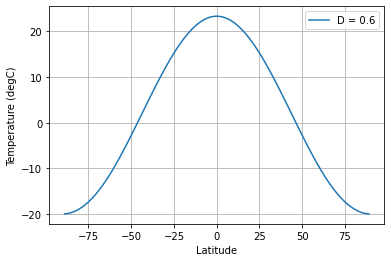

In [19]:
model = climlab.EBM_annual(name='EBM', A=210, B=2, D=0.6, a0=a_0, a2=a_1, a4=a_2)
model.integrate_years(10)

fig,ax = plt.subplots()
ax.plot(model.lat, model.Ts, label=('D = %0.1f' %D))
ax.set_ylabel('Temperature (degC)')
ax.set_xlabel('Latitude'); ax.legend(); ax.grid();

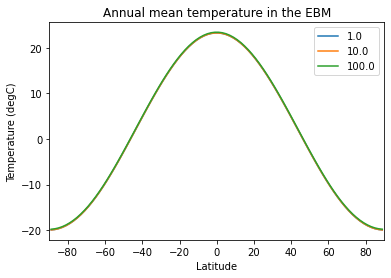

In [20]:
#  for convenience, set up a dictionary with our reference parameters
param = {'A':210, 'B':2, 'a0':a_0, 'a2':a_1, 'a4':a_2, 'D':0.6}

#  We can pass the entire dictionary as keyword arguments using the ** notation
model1 = climlab.EBM_seasonal(**param, name='Seasonal EBM')
model1

#  We will try three different water depths
water_depths = np.array([1., 10., 100.])

num_depths = water_depths.size
Tann = np.empty( [model1.lat.size, num_depths] )
models = []

for n in range(num_depths):
    ebm = climlab.EBM_seasonal(water_depth=water_depths[n], **param)
    models.append(ebm)
    models[n].integrate_years(20., verbose=False )
    models[n].integrate_years(1., verbose=False)
    Tann[:,n] = np.squeeze(models[n].timeave['Ts'])
    
    
lat = model1.lat
fig, ax = plt.subplots()
ax.plot(lat, Tann)
ax.set_xlim(-90,90)
ax.set_xlabel('Latitude')
ax.set_ylabel('Temperature (degC)')
ax.set_title('Annual mean temperature in the EBM')
ax.legend( water_depths )


In [21]:
ncep_url = "http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_Ts = xr.open_dataset(ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc", decode_times=False)
# Alternative source from the University of Hawai'i
#url = "http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/NCEP/NCEP/clima/"
#ncep_Ts = xr.open_dataset(url + 'surface_gauss/skt')
lat_ncep = ncep_Ts.lat; lon_ncep = ncep_Ts.lon
Ts_ncep = ncep_Ts.skt
print( Ts_ncep.shape)

maxTs = Ts_ncep.max(dim='time')
minTs = Ts_ncep.min(dim='time')
meanTs = Ts_ncep.mean(dim='time')

(12, 94, 192)


In [22]:
num_steps_per_year = int(model1.time['num_steps_per_year'])
Tyear = np.empty((lat.size, num_steps_per_year, num_depths))
for n in range(num_depths):
    for m in range(num_steps_per_year):
        models[n].step_forward()
        Tyear[:,m,n] = np.squeeze(models[n].Ts)
        
        

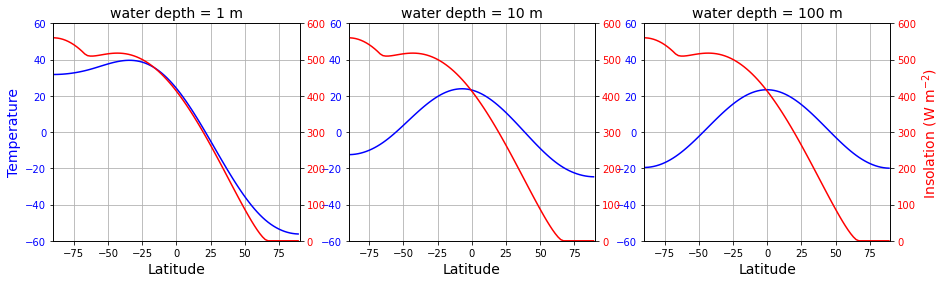

In [23]:
def initial_figure(models):
    fig, axes = plt.subplots(1,len(models), figsize=(15,4))
    lines = []
    for n in range(len(models)):
        ax = axes[n]
        c1 = 'b'
        Tsline = ax.plot(lat, models[n].Ts, c1)[0]
        ax.set_title('water depth = %.0f m' %models[n].param['water_depth'], fontsize=14 )
        ax.set_xlabel('Latitude', fontsize=14 )
        if n == 0:
            ax.set_ylabel('Temperature', fontsize=14, color=c1 )
        ax.set_xlim([-90,90])
        ax.set_ylim([-60,60])
        for tl in ax.get_yticklabels():
            tl.set_color(c1)
        ax.grid()

        c2 = 'r'
        ax2 = ax.twinx()
        Qline = ax2.plot(lat, models[n].insolation, c2)[0]
        if n == 2:
            ax2.set_ylabel('Insolation (W m$^{-2}$)', color=c2, fontsize=14)
        for tl in ax2.get_yticklabels():
            tl.set_color(c2)
        ax2.set_xlim([-90,90])
        ax2.set_ylim([0,600])
        lines.append([Tsline, Qline])
    return fig, axes, lines
def animate(step, models, lines):
    for n, ebm in enumerate(models):
        ebm.step_forward()
        #  The rest of this is just updating the plot
        lines[n][0].set_ydata(ebm.Ts)
        lines[n][1].set_ydata(ebm.insolation)
    return lines
#  Plot initial data
fig, axes, lines = initial_figure(models)

In [24]:
#  Some imports needed to make and display animations
from IPython.display import HTML
from matplotlib import animation

num_steps = int(models[0].time['num_steps_per_year'])
ani = animation.FuncAnimation(fig, animate, 
        frames=num_steps,
        interval=80,
        fargs=(models, lines),
        )
HTML(ani.to_html5_video())

Given your calibrated albedo profile, what do your plots tell us the average annual temperature should be in Northern Scotland? How about the arctic? 

What rough min and max temperatures do you estimate are reached in northern scotland and the arctic each year? 

How do these compare to reality?

['builtins',
 'builtins',
 'numpy',
 'matplotlib.pyplot',
 'xarray',
 'climlab',
 'climlab.utils.constants',
 'climlab.utils.legendre',
 'types']

In [10]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

xarray==0.20.1
numpy==1.20.3
matplotlib==3.5.0
climlab==0.7.12
